<a href="https://colab.research.google.com/github/Nancy123a/LDSL-Winter-school/blob/main/MSCtask_MASC_EN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" style="padding-right:10px;" width=100, height=100, src="https://ldsl.rub.de/assets/images/brand/logo.svg">
<br></br>
<br></br>

# LDSL Winter school 
## Workshop: NN in Python


-----
# Group task: Reimplementation of modal sense classification

-----
In this notebook we will implement a neural network for modal sense classification and try to adapt the architecture of a **convolutional neural** network as propsed in Germies (2020) and train, develop and test on a different data set. 

As a data set we will use a version of the MSC corpus collection tagged with modal sense classes for English modal verbs: *can, must, may, should* and *could*. 

The idea is that you work in your groups together on this task. You might use code from the notebook that we discussed in detail, but you will also find some help of what to do in this template for you. We don't want you to compete in this task against the other groups, but will meet to discuss the subtasks and exchange ideas and help each other.

You should follow the general instructions on the task in this notebook, but we also don't want to limit your possibilities in achieving best results in this task. So there will be some decisions to make in your group and you SHOULD feel free to go beyond the instructions: try variants, make proposals for improvements, new ideas whatever occurs to you that might be relevant in this task. 

Overview: 
* Subtask I: Choose and load a dataset
* Subtask II: Data exploration/visualisation
* Subtask III: Choose Task specification
* Subtask IV: Preprocessing
* Subtask V: Defining model
* Subtask VI: Training/validation and testing


In [ ]:
# Some libraries we previously used and might need

import os
import sys
import pandas as pd
import numpy as np
from numpy import array
import string
import glob
import csv
import re
import matplotlib.pyplot as plt

In [ ]:
# Machine Learning Libraries

%tensorflow_version 2.x # tensorflow magic, only to be used in google colab. comment out if using other editor/environment

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dense, Activation, Dropout, Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers, regularizers

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x # tensorflow magic, only to be used in google colab. comment out if using other editor/environment`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


# Define overall task and subtasks

Overall task: MSC is the task to decide which sense is appropriate for a modal verb in context. It is kind of a sense disambiguation task. The advantage of modal verbs is that the inventory of forms and senses is relatively fixed. Now you remember that Germies aimed at a **two class classification** into deontic and epistemic senses (dismissing dynamic ones).  

---


## Subtask I
**Choose and load a dataset**

In the [MSC](https://doi.org/10.11588/data/JEESIQ) collection (Marasović, Zhou,& Frank 2019) there are three reported datasets: MASC, MPQA, EPOS-E. 

See distribution of available modality datasets in MSC collection for English (cf. Marosovic & Frank 2016):

| corpus|class|can| could |may |must| should|
|--|--|--|--|--|--|--|
|MASC|ep| 88| 144| 217 |29 |27|
|MASC|de| 72| 16 |43| 115| 224|
|MASC|dy| 710| 251 |3 |-| –|
|MPQA|ep|2|	156|130|11|26|
|MPQA|de|115|17|	9	|83|	248|
|MPQA|dy|271|	67|	–|	–|	–|
|EPOS-E|ep|150|40|950	|800	|150|
|EPOS-E|	de|150|40	|950|800|	150|
|EPOS-E|	dy|150|40	|-|	–|–|

If you download it, you will recognize that it actually contains only MASC data with available texts and labels; For MPQA and EPOS-E there are only files that include a reference to an id but not the texts.

I managed to obtain the underlying EPOS-E data from here: https://github.com/amarasovic/modal-sense-classifcation/tree/master/data/EPOS_E.

I then build a new dataset from MASC (several genres), EPOS-E (movie subtitles) and a heuristics.txt file included in their collection such that 5376 texts remained. Now this yielded more data, but these are now mixed from different corpora and you will not be able to compare it to the authors' datasets.  

 The labels are still uniform:
>* dy: dynamic = capability 
>* ep: epistemic = possibility
>* de: deontic = permission or obligation

So you can now choose to use MASC (about ~ 1795 texts) or use my collection (~5376 texts) if you want to have more data.  I filtered out all duplicates and excluded 3 instances of an undocumented category 'other' and 9 instances of the modal verb *shall*.

* OPTION I: MASC corpus from csv-file

* OPTION II: Load collection from csv-file

Regardless of the option you might take, we will have a representation in a pandas dataframe that contains the following information: sentence, modal tag of sense class and modal verb ('sent', 'mtag', 'mverb'). Note that information about the form of the modal verb was contained in the filenames! It means that the sense tag in the file only applies to this modal verb. But still we might keep in mind that there may be sentences with more than one modal verb in our data. I kept the information about individual modal verbs, but you might drop it later. Germies made subsets for each modal verb to evaluate them in the end, but that's optional.

Example:

|index|sent 	|mtag| 	mverb|
|---|----|---|----|
|0 | But that 's the reason why I had asked if we c... |	dy| 	could|
|1 |	As a result of that , Mr. Barna and I have spe...| 	dy| 	could|
|2 |	So that raises an issue for us because clearly...| 	dy| 	could|


In [ ]:
# mount drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load csv files
# filepath MASC: /content/drive/MyDrive/Workshop_NN_in_Python/MSC/masc_data.csv
# filepath collection: /content/drive/MyDrive/Workshop_NN_in_Python/MSC/all_my_msc.csv
data_loaded = pd.read_csv(filepath_or_buffer="/content/drive/MyDrive/all_my_msc.csv", sep=',', encoding="utf8")
data_loaded_original = data_loaded


## Subtask II 
**Data exploration/Visualization**

Write a function and/or use plots to explore the data distribution for modal tags, modal verbs and for modal tags across modal verbs.
* Think about the balancedness of data sets and what options for classification you have.
* Think about decisions on cleaning during your explorations and collect ideas about possible options.

---

Some hints or ideas for cleaning that you might consider for later preprocessing:
- Pay attention that there might be different kind of contraction forms in the data *I 'm, could n't*. Think about what would happen if you only keep alphabet characters. 
- We might expand the contractions and want to preserve information about the negation of modals, because it might interact with certain modal senses, we dont know, but it could help. 
- During qualification task some noted in the text there are variants of *ca n't* etc. that we could normalize.

In [ ]:
import seaborn as sns

In [ ]:
"""Takes a data frame and returns another data frame where values are counted according to their attributes"""
modals = pd.pivot_table(data_loaded[["mtag", "mverb"]], 
                        values="mverb",  # selects only one set of values (otherwise it would be two)
                        index="mtag",  # row index
                        columns ="mverb",
                        aggfunc=lambda x: x.count(),  # creates lambda function which counts occurrences
                        fill_value=0)  # NA will be replaced by zero
print(modals)


mverb   can  could   may  must  should
mtag                                  
de      189     56   181   686     565
dy     1032    343     3     0       0
ep       96    306  1189   677      53


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


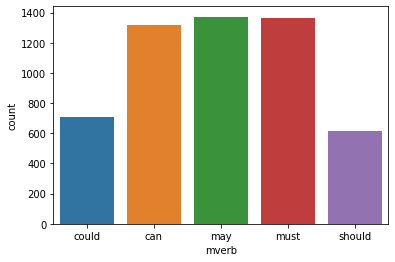

In [ ]:
sns.countplot(data_loaded['mverb'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9aae1bae50>,
      dtype=object)

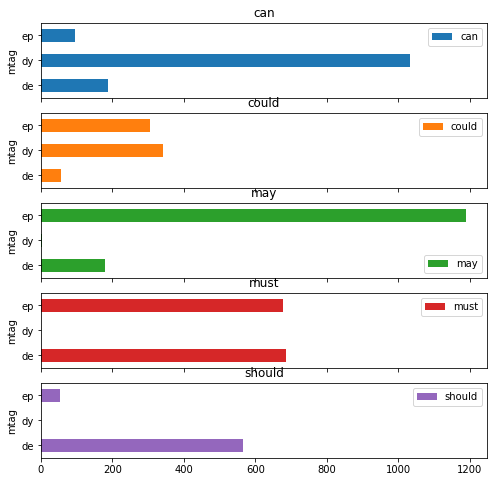

In [ ]:
modals.plot(kind="barh", subplots=True, figsize=(8,8))


In [ ]:
# Determine max / mean sentence length
x = [len(s.split()) for s in data_loaded['sent']]
max_len = max(x)
mean_len = np.mean(x)
print('max length: %d' %max_len)
print('mean length: %d' %mean_len)

max length: 80
mean length: 21


## Subtask III
**Task specification**

Consider that options you have and write down the classification task you aim at. 



Classification of semantic function of modal verbs in epistemic, dynamic or deontic function for the modal verbs "can", "could", "may", "must", "should".




## Subtask IV
**Preprocessing**

There are severals steps of preprocessing to take into account. I will list a few and you should discuss in which order to apply them makes most sense to you. 

* Cleaning according to your ideas in the previous step
* Split text (X) and labels/modal tags (Y)
* You should necessarily at some point arrive at a train/validate/test split of your data set. You can import the function `from sklearn.model_selection import train_test_split` (cf. [docu](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)). If you have very imbalanced data, you could take the parameter `stratify=y` into account. 
* Convince yourself that portions and shapes of your data are correct.
* It's optional to make sub sets for individual modal verbs and train and evaluate separately in comparison to complete dataset. 
* It may be necessary to convert your data to numpy arrays.
* Reuse Germies' (2020) functions or use similar functions for getting English word embeddings. You can use e.g. Flairs embeddings: 'en-crawl'. 
* Consider text length and use padding.
* Convert the modal sense labels to one-hot-vectors. 

After preprocessing, your data must be ready to be fed into the model.

Handling of the following regular expresions when contractions are found:
  *   "ca n't"
  *   "couldn ’ t"
  *   "could n't"
  *   "should n't"
  *   "must n't"

In [ ]:
# working method
import re
pattern = r"c ?a ?n ?'t|could ?n ?'t|should ?n ?'t|must ?n ?'t" 
for id,sentence in enumerate(data_loaded['sent']):
  modals=re.findall(pattern, sentence)
  if len(modals)>0:
    for modalverb in modals:
      if re.match("c ?a ?n ?'t", modalverb):
        data_loaded['sent'][id] = sentence.replace(modalverb,modalverb.replace(" ","").replace("n't","n not"))
      else:
        data_loaded['sent'][id] = sentence.replace(modalverb,modalverb.replace(" ","").replace("n't"," not"))



may     1373
must    1363
can     1317
Name: mverb, dtype: int64
1323


In [ ]:
# Negations handling

negations = ["ca n't", "couldn ’ t", "could n't", "should n't", "must n't"]
replacements = ["can not", "could not", "could not", "should not", "must not"]

for id, sentence in enumerate(data_loaded['sent']):
  for index, neg in enumerate(negations):
    if (sentence.find(neg) != -1):
      data_loaded['sent'][id] = sentence.replace(neg, replacements[index])


In [ ]:
# Split training / test data
X_train, X_test, y_train, y_test = train_test_split(data_loaded['sent'], data_loaded['mtag'], test_size = 0.2, random_state= 42)

# Split training /validation data
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state= 42)



In [ ]:
# Converting to numpy arrays

X_test = np.array(X_test)
y_test = np.array(y_test)
x_train = np.array(x_train)
x_val = np.array(x_val)
y_train = np.array(y_train)
y_val = np.array(y_val)


In [ ]:
x_train.shape

(3440,)

In [ ]:
# cf. Germies (2020) code and modify in case you need
# Encode Texts into Word Embeddings

# Flair Word Embeddings
!pip install flair
from flair.embeddings import WordEmbeddings
from flair.data import Sentence

def embed_x(cleanTexts):
  embeddings = WordEmbeddings('en-crawl') # load Flair embeddings
  embeddedSents = []
  for text in cleanTexts:
    sent = Sentence(text)
    # transform each sentence into word vector sequence
    embeddings.embed(sent) 
    embeddedSents.append([t.embedding.numpy() for t in sent])
  return embeddedSents

# Padding

def pad_x(embeddedSents):
  #200 pad embeddings to have same length
  padded = pad_sequences(embeddedSents, padding= 'post', dtype='float32', truncating = 'post', maxlen = 100)
  return padded

# Note: Max Length for the Dataset is a Number of 100 Words per Sequence Punctuation and other Symbols excluded

In [ ]:
# Encode Labels into Categorical One-Hot Vectors

def encode_y(labels):
  label_encoder = LabelEncoder()
  # transform string labels into integers
  int_encoded = label_encoder.fit_transform(labels) 
  # transform integers into n-dimensional one-hot encodings
  onehot_encoded = to_categorical(array(int_encoded)) 
  return onehot_encoded

In [ ]:
# Remove Punctuation Marks and Symbols from Texts

def clean_x(texts):
  cleanTexts = []
  for sent in texts:
    #remove punctuation, integer and other symbols
    stripped = [w for w in sent.split() if w.isalpha()] 
    # join the remaining alphabet characters with whitespace
    stripped = ' '.join(stripped)
    cleanTexts.append(stripped)
  return cleanTexts

In [ ]:
# Process Train Set 

# Text Sequences
X_texts = x_train
X_clean = clean_x(X_texts) # embed texts
X_emb = embed_x(X_clean)
X_train = pad_x(X_emb) # pad texts

# Labels
Y_train = encode_y(y_train)

In [ ]:
# Process Validation Set 

# Text Sequences
x_texts = x_val
x_clean = clean_x(x_texts) #texts
x_emb = embed_x(x_clean)
x_val = pad_x(x_emb)

# Labels
y_val = encode_y(y_val)

In [ ]:
# Process Test Set 

# Text Sequences
x_texts = X_test
x_clean = clean_x(x_texts) #texts
x_emb = embed_x(x_clean)
x_test = pad_x(x_emb)

# Labels
y_test = encode_y(y_test)

In [ ]:
print(Y_train.shape)
print(X_train.shape)

(3440, 3)
(3440, 100, 300)


## Subtask V

**Defining Model** 

* Modify Germies' model below where you would need to.
* Check input shape and output shape.
* Check recommended activation function in the last layer such that it matches your classification task. 
* Select recommended loss function depending on the classification task you chose.

In [ ]:
# Define One-Layer Multi-Channel Architecture

def define_model(length, dims): #sequence length, vocab size/embedding dims
  # channel 1
  inputs1 = Input(shape=(length, dims))
  conv1 = Conv1D(filters = 128, kernel_size = 4, activation = 'relu', activity_regularizer=regularizers.l2(0.001))(inputs1)#(embedding1) #filter size 4
  drop1 = Dropout(0.5)(conv1) # higher drop out = slower and more consistent learning
  pool1 = MaxPooling1D(pool_size = 2)(drop1)
  flat1 = Flatten()(pool1)
  # channel 2
  inputs2 = Input(shape=(length, dims))
  conv2 = Conv1D(filters = 128, kernel_size = 6, activation = 'relu', activity_regularizer=regularizers.l2(0.001))(inputs2)#(embedding2) #filter size 6
  drop2 = Dropout(0.5)(conv2)
  pool2 = MaxPooling1D(pool_size = 2)(drop2)
  flat2 = Flatten()(pool2)
  # channel 3
  inputs3 = Input(shape=(length, dims))
  conv3 = Conv1D(filters = 128, kernel_size = 8, activation = 'relu', activity_regularizer=regularizers.l2(0.001))(inputs3) #(embedding3) #filter size 8
  drop3 = Dropout(0.5)(conv3)
  pool3 = MaxPooling1D(pool_size = 2)(drop3)
  flat3 = Flatten()(pool3)
  # merge layer
  merged = concatenate([flat1, flat2, flat3])
  dense1 = Dense(10, activation = 'relu', activity_regularizer=regularizers.l2(0.001))(merged) #reg!
  outputs = Dense(3, activation = 'softmax', activity_regularizer=regularizers.l2(0.001))(dense1) # regularizer slows down learning
  model = Model(inputs = [inputs1, inputs2, inputs3], outputs  = outputs)
  # compile
  model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(learning_rate = 0.001), metrics = ['accuracy']) #0.0001 lower lr to counteract fast overfitting
  # summary 
  print(model.summary())

  return model

In [ ]:
model = define_model(100, 300) #95, 300

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None, 100, 300)]   0                                            
__________________________________________________________________________________________________
input_34 (InputLayer)           [(None, 100, 300)]   0                                            
__________________________________________________________________________________________________
input_35 (InputLayer)           [(None, 100, 300)]   0                                            
__________________________________________________________________________________________________
conv1d_32 (Conv1D)              (None, 97, 128)      153728      input_33[0][0]                   
___________________________________________________________________________________________

## Subtask VI 
**Training and validation** / **Testing**

* Modify code below from Germies to take your training and validation portion of data. Note that x_train and x_dev is used three times each as an input because we have three channels.

* Draw plots for accuracy and loss during training and comment how you interpret them. 

* Finally:  Only apply model to test data once you are sure you won't change it. Evaluate model on all test data. (It's optional to evaluate subsets for individual modal verbs.)

In [ ]:
# Training on Train and Dev Set

history = model.fit(x = [X_train, X_train, X_train], y = Y_train, validation_data = ([x_val, x_val, x_val], y_val), shuffle = True, epochs = 20, batch_size = 16) #16

Epoch 1/20
215/215 [==============================] - 19s 89ms/step - loss: 0.5436 - accuracy: 0.8340 - val_loss: 0.5986 - val_accuracy: 0.8058
Epoch 2/20
215/215 [==============================] - 19s 87ms/step - loss: 0.2903 - accuracy: 0.9448 - val_loss: 0.5950 - val_accuracy: 0.7930
Epoch 3/20
215/215 [==============================] - 19s 88ms/step - loss: 0.1626 - accuracy: 0.9869 - val_loss: 0.5596 - val_accuracy: 0.8093
Epoch 4/20
215/215 [==============================] - 19s 88ms/step - loss: 0.1055 - accuracy: 0.9956 - val_loss: 0.5820 - val_accuracy: 0.8035
Epoch 5/20
215/215 [==============================] - 19s 87ms/step - loss: 0.0796 - accuracy: 0.9983 - val_loss: 0.5765 - val_accuracy: 0.7953
Epoch 6/20
215/215 [==============================] - 19s 87ms/step - loss: 0.0639 - accuracy: 0.9988 - val_loss: 0.5781 - val_accuracy: 0.7919
Epoch 7/20
215/215 [==============================] - 19s 87ms/step - loss: 0.0599 - accuracy: 0.9983 - val_loss: 0.6325 - val_accuracy:

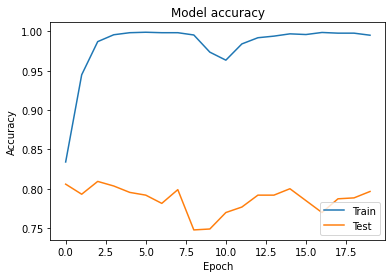

In [ ]:
# Plot training & validation accuracy values

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test', 'Classes'], loc='lower right')
plt.show()


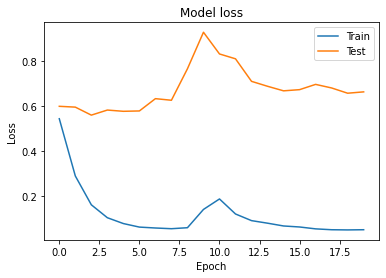

In [ ]:
# Plot training & validation loss values

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
# Test

# References

Germies, J. (2020). On the Generalization Capability of CNN Models for Modal Sense Classification. Manuscript, Ruhr University Bochum. 

Marasović, A. & Frank, A. (2016). Multilingual modal sense classification using a convolutional neural network. In *Proceedings of the 1st Workshop on Representation Learning for NLP*, pp. 111–120, Berlin, Germany.
URL https://www.aclweb.org/anthology/W16-1613  

Marasović, A., Zhou, M., & Frank, A. (2019). ”The MSC Data Set”. URL
https://doi.org/10.11588/data/JEESIQ, heiDATA, V1.
